In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.sentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
import re
from datetime import datetime, timedelta

# Load the data
df = pd.read_csv('karcher_reviews.csv')

# Display the first few rows and basic information
print(df.head())
print(df.info())

                                                text  rating    author  \
0  Very easy to look up and order parts order par...       5    Ed3000   
1  Fast shipping and arrived with no damages. Hig...       5     David   
2  Excellent service! I was notified every step o...       5   Dave244   
3  Prompt shipping and well packed. Had no broken...       5      Axel   
4  Very good shopping experience. Love the new Ka...       5  BikeMike   

         date  
0   a day ago  
1  2 days ago  
2  2 days ago  
3  4 days ago  
4  4 days ago  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3243 entries, 0 to 3242
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    3243 non-null   object
 1   rating  3243 non-null   int64 
 2   author  3233 non-null   object
 3   date    3243 non-null   object
dtypes: int64(1), object(3)
memory usage: 101.5+ KB
None


In [7]:

# Function to convert relative date to actual date
def convert_relative_date(date_str, reference_date):
    if 'day ago' in date_str or 'days ago' in date_str:
        days = 1 if date_str == 'a day ago' else int(re.search(r'\d+', date_str).group())
        return reference_date - timedelta(days=days)
    elif 'month ago' in date_str or 'months ago' in date_str:
        months = 1 if date_str == 'a month ago' else int(re.search(r'\d+', date_str).group())
        return reference_date - pd.DateOffset(months=months)
    elif 'year ago' in date_str or 'years ago' in date_str:
        years = 1 if date_str == 'a year ago' else int(re.search(r'\d+', date_str).group())
        return reference_date - pd.DateOffset(years=years)
    else:
        return pd.to_datetime(date_str)  # For any dates already in a standard format

# Load the data
df = pd.read_csv('karcher_reviews.csv')

# Set the reference date (today's date in the context)
reference_date = datetime(2024, 6, 29)

# Create new date column
df['actual_date'] = df['date'].apply(lambda x: convert_relative_date(x, reference_date))

# Display the first few rows to verify
print(df[['date', 'actual_date']].head())

# Basic statistics about the date range
print(f"Date range: {df['actual_date'].min()} to {df['actual_date'].max()}")

         date actual_date
0   a day ago  2024-06-28
1  2 days ago  2024-06-27
2  2 days ago  2024-06-27
3  4 days ago  2024-06-25
4  4 days ago  2024-06-25
Date range: 2019-06-29 00:00:00 to 2024-06-28 00:00:00


Average rating: 4.360468701819303
Number of reviews: 3243
Date range: 2019-06-29 00:00:00 to 2024-06-28 00:00:00


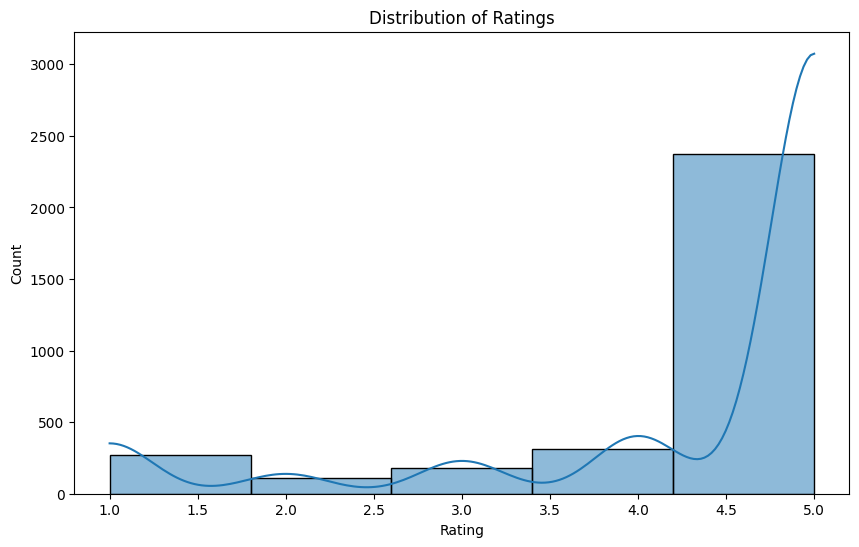

In [8]:
# Calculate basic statistics
print("Average rating:", df['rating'].mean())
print("Number of reviews:", len(df))
print("Date range:", df['actual_date'].min(), "to", df['actual_date'].max())

# Plot rating distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['rating'], bins=5, kde=True)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

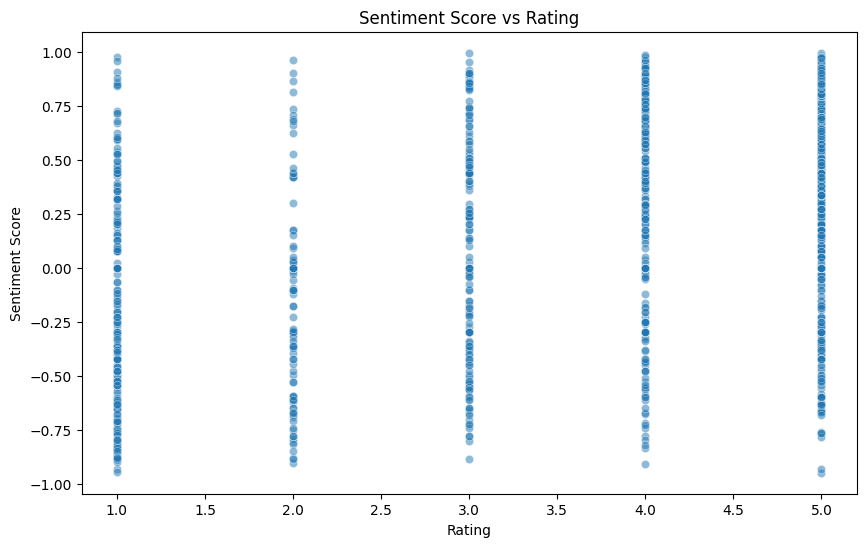

In [9]:
# Initialize sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Function to get sentiment scores
def get_sentiment(text):
    return sia.polarity_scores(text)['compound']

# Apply sentiment analysis
df['sentiment'] = df['text'].apply(get_sentiment)

# Plot sentiment vs rating
plt.figure(figsize=(10, 6))
sns.scatterplot(x='rating', y='sentiment', data=df, alpha=0.5)
plt.title('Sentiment Score vs Rating')
plt.xlabel('Rating')
plt.ylabel('Sentiment Score')
plt.show()

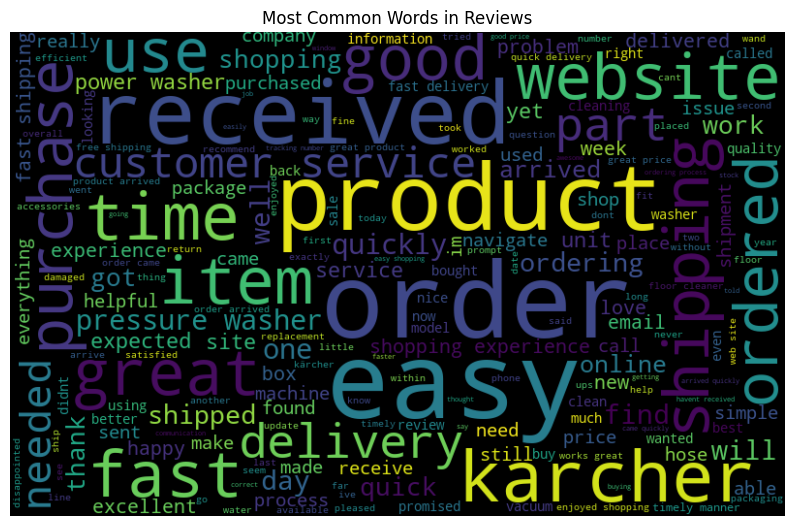

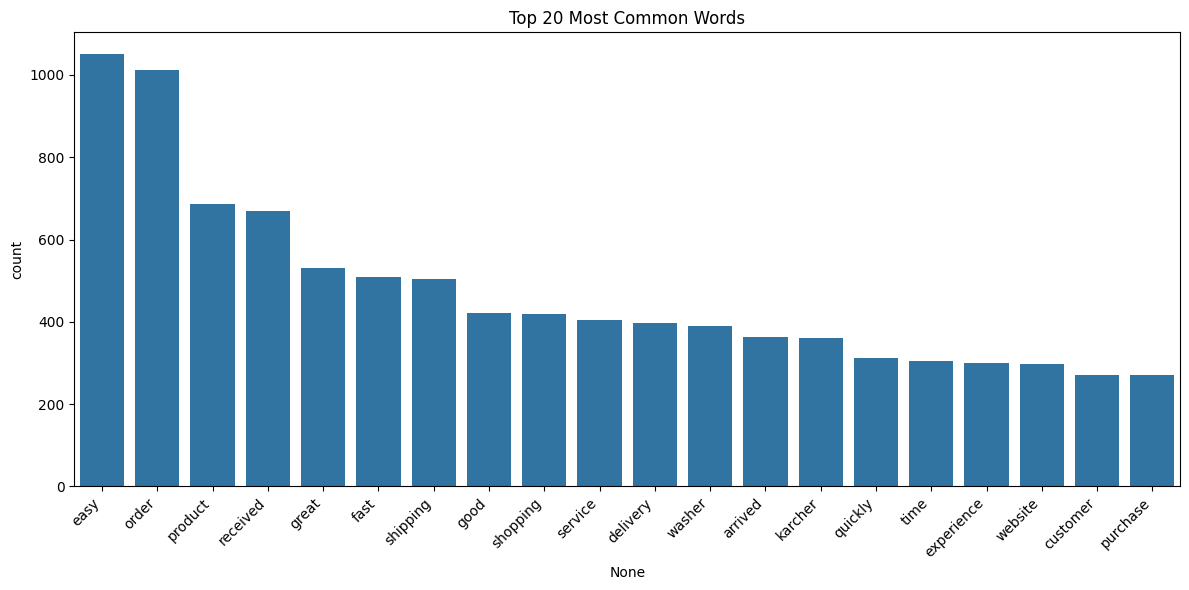

In [11]:
# Function to clean text
def clean_text(text):
    text = re.sub(r'[^\w\s]', '', str(text).lower())
    return text

# Clean the text
df['clean_text'] = df['text'].apply(clean_text)

# Create word cloud
all_words = ' '.join(df['clean_text'])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Most Common Words in Reviews')
plt.show()

# Get most common words
vectorizer = CountVectorizer(stop_words='english')
word_count = vectorizer.fit_transform(df['clean_text'])
words = pd.DataFrame(word_count.sum(axis=0).T, columns=['count'])
words.index = vectorizer.get_feature_names_out()
top_words = words.sort_values('count', ascending=False).head(20)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_words.index, y='count', data=top_words)
plt.title('Top 20 Most Common Words')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

/var/folders/5q/f40382gn3lxgmyf4m7grw_080000gp/T/ipykernel_17263/1836252466.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = df.set_index('actual_date').resample('M').agg({'rating': 'mean', 'sentiment': 'mean'})


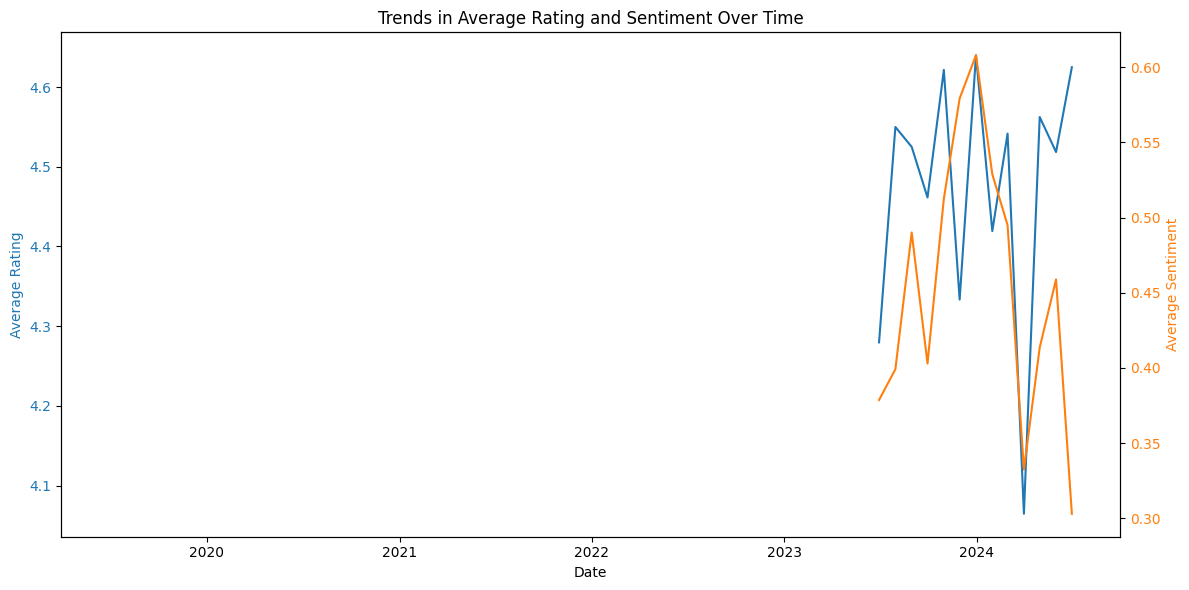

In [13]:
# Resample by month and calculate average rating and sentiment
monthly_data = df.set_index('actual_date').resample('M').agg({'rating': 'mean', 'sentiment': 'mean'})

# Plot trends
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.set_xlabel('Date')
ax1.set_ylabel('Average Rating', color='tab:blue')
ax1.plot(monthly_data.index, monthly_data['rating'], color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Average Sentiment', color='tab:orange')
ax2.plot(monthly_data.index, monthly_data['sentiment'], color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

plt.title('Trends in Average Rating and Sentiment Over Time')
fig.tight_layout()
plt.show()